# Notebook Purpose and Summary

This notebook read multiple radio instrument data files with the goal of **removing backgroud noise** (`BG_EIRP`), form measured signal power ('EIRP`).


## Purpose

- Load multiple instrument measurement file (in CSV format);
- Clean missing data **Independently for each file**
- Subtract the backgroud signal in **logaritmic scale**:
    -- this proceess is made in two stages, where first will be converted to **linear scale**, to be able to perfome the substraction.
- Save the instrument signal on a new dataframe

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import os

from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, savgol_filter 
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import mean_squared_error



In [2]:
# #plots layout
from matplotlib import rc
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager
import matplotlib.colors as colors


plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18


SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


In [3]:
# Read the csv files

folder = "Data/Additional_EIRPs"  # path for folder
files = glob.glob(os.path.join(folder, "*.csv"))

# Dictionary to store each instrument's data
data = {}

for file in files:
    # Get file base name without extension (e.g., camera, radio)
    label = os.path.splitext(os.path.basename(file))[0]
    
    # Load CSV into a DataFrame
    df = pd.read_csv(file)
    
    # Store in the dictionary
    data[label] = df

In [4]:
# inspect the dataframe
for instrument_name, df in data.items():
    print(f"\nColumns in {instrument_name}:")
    print(df.columns.tolist())


Columns in Kiricom_Radio_On_MAX_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in Superfire_HL58_Headlamp_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in ALS_Bakkie_CAA567123_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in 2020_02_11_INCA_Camera_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']


# Visualise the measurements


/tmp/ipykernel_5453/3049494374.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


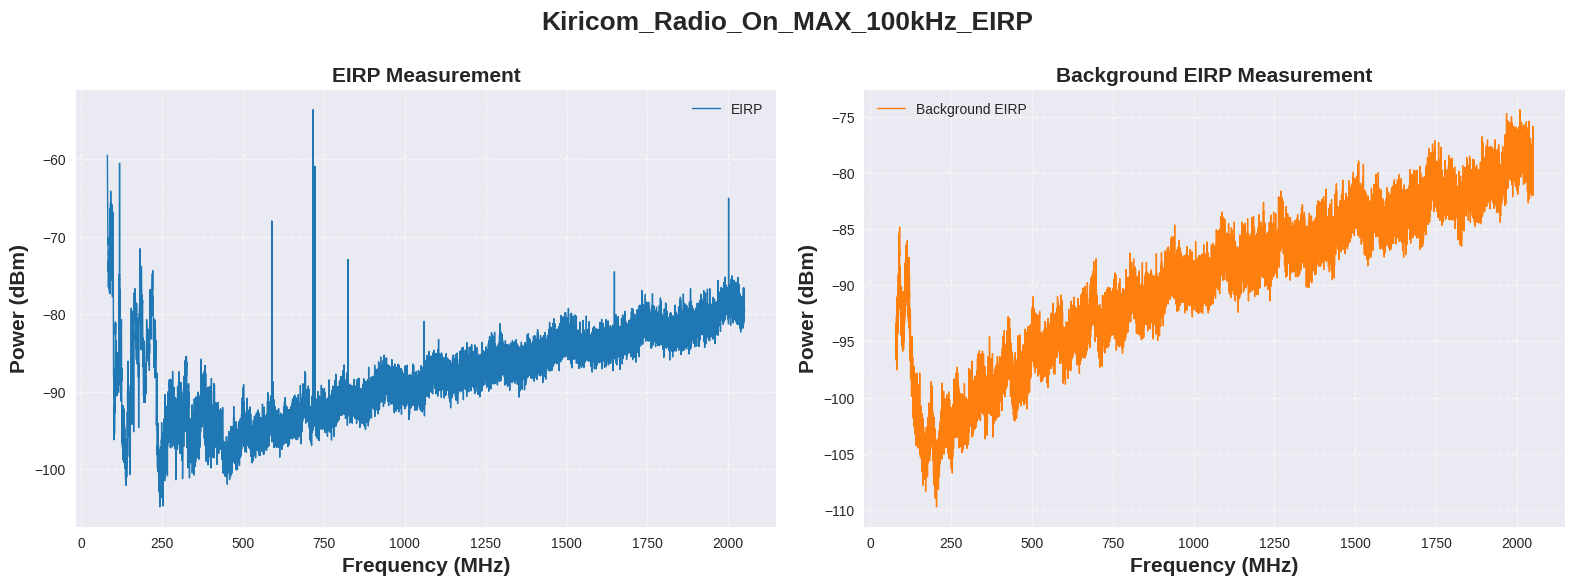

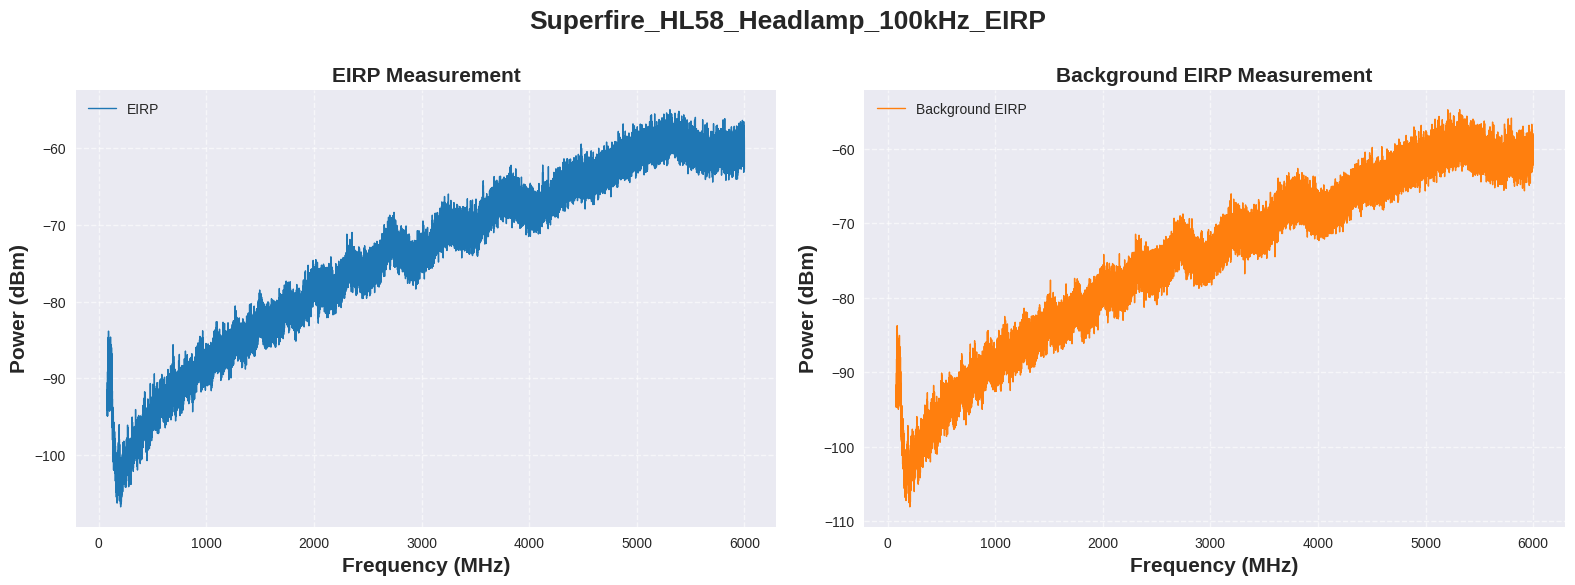

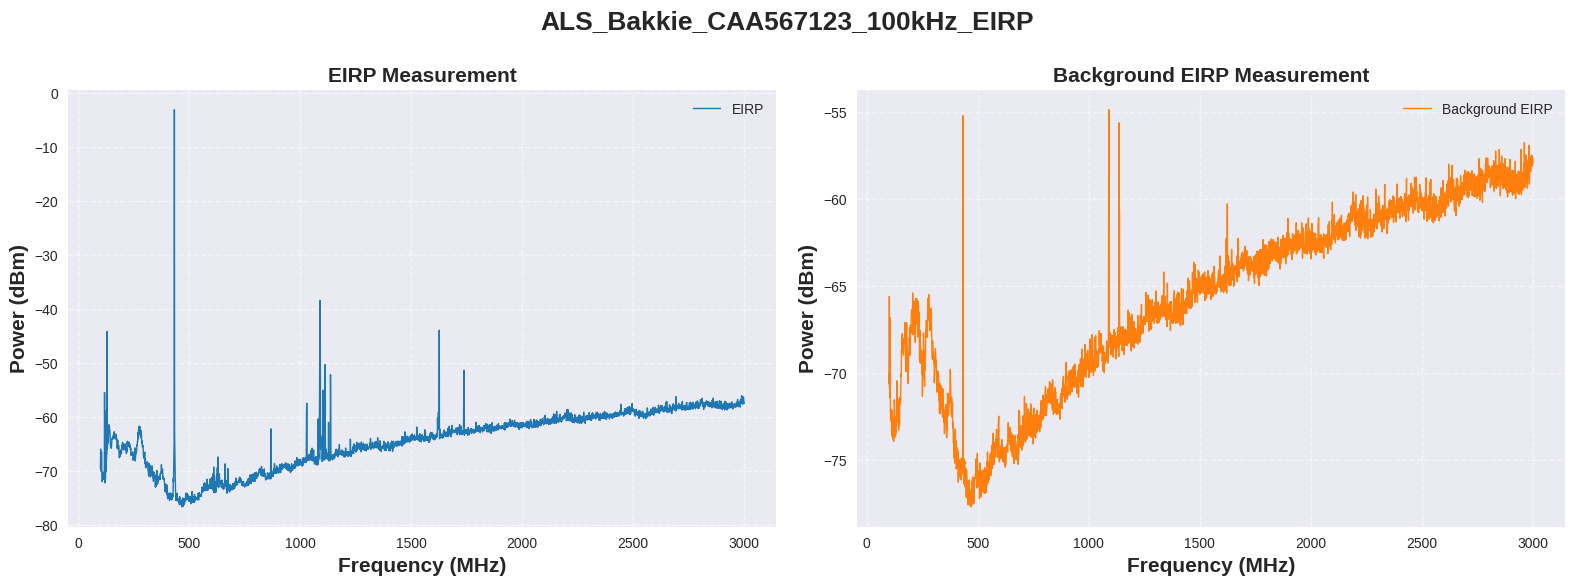

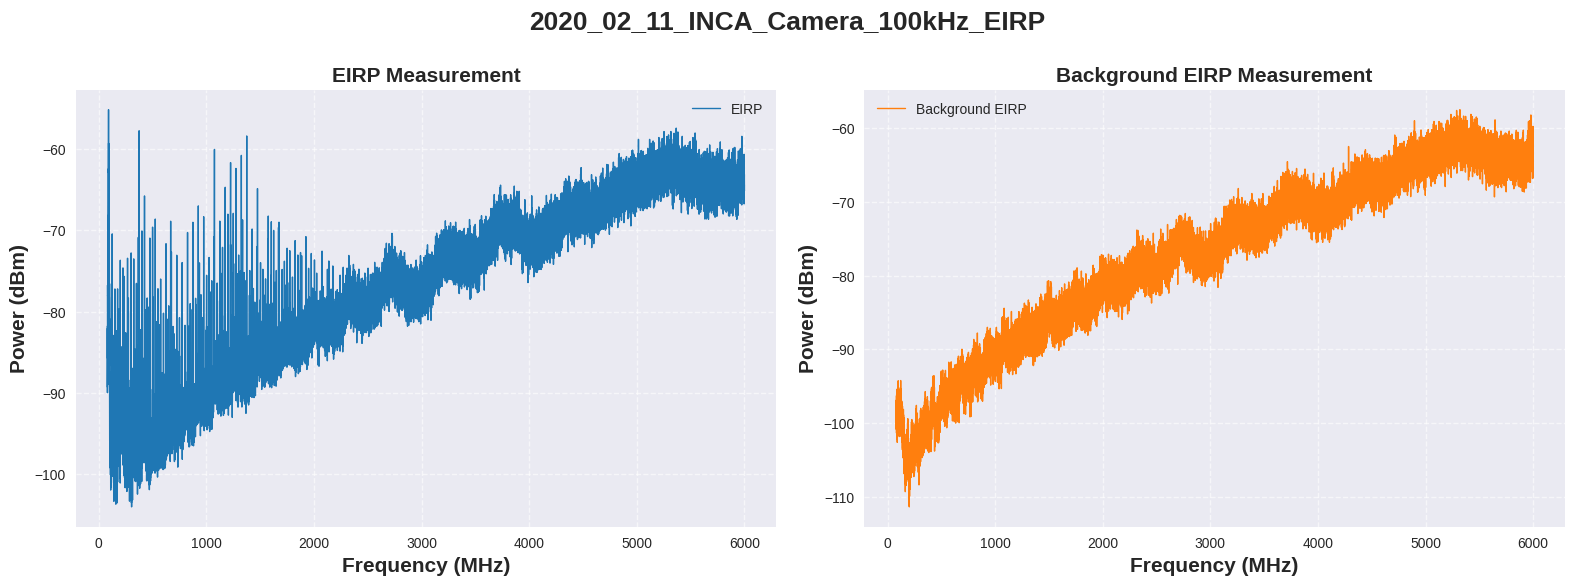

In [11]:
# Set style for better visual appearance
plt.style.use('seaborn')

for instrument_name, data_plot in data.items():
    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{instrument_name}', fontweight='bold')
    
    # Plot EIRP data
    axs[0].plot(data_plot['Frequency(MHz)'], data_plot['EIRP(dBm)'], 
               color='tab:blue', linewidth=1, label='EIRP')
    axs[0].set_xlabel('Frequency (MHz)', fontweight='bold',fontsize=15)
    axs[0].set_ylabel('Power (dBm)', fontweight='bold',fontsize=15)
    axs[0].set_title('EIRP Measurement', fontweight='bold',fontsize=15)
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].legend()
    
    # Plot Background EIRP data
    axs[1].plot(data_plot['Frequency(MHz)'], data_plot['BG_EIRP(dBm)'], 
               color='tab:orange', linewidth=1, label='Background EIRP')
    axs[1].set_xlabel('Frequency (MHz)', fontweight='bold', fontsize=15)
    axs[1].set_ylabel('Power (dBm)', fontweight='bold',fontsize=15)
    axs[1].set_title('Background EIRP Measurement', fontweight='bold', fontsize=15)
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].legend()
    
    # Adjust layout and display
    plt.tight_layout()

    # save the plot
    plt.savefig('Plots/'+instrument_name+'.png', bbox_inches='tight')

    #break

# Remove the back groud signal 

To remove the back-group noite:
1. convert the measurements form (dBm) to mW, i.e, from log-scale for liner scale.
2. perfome the substraction of the back-groud 
3. convert back to log scale

In [6]:
# define a fuctional to remove the backgound noise

def bg_remove(signal, background):
     """
    Args:
    signal: mesurements of the instrument + noise
    background: mesurement of the background

    Return:
    clean_signal: signal of the instrument
    """
     
    # convert log scale to linear scale
     signal_mW = 10**(signal/10)
     background_mW = 10**(background/10)

    # Subtract background in linear scale
     clean_mW = signal_mW - background_mW
     clean_mW[clean_mW <= 0] = np.nan

    # Convert back to dBm
     clean_signal = 10 * np.log10(clean_mW)
     
     print(type(clean_signal))

     return clean_signal



/tmp/ipykernel_5453/1096535012.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


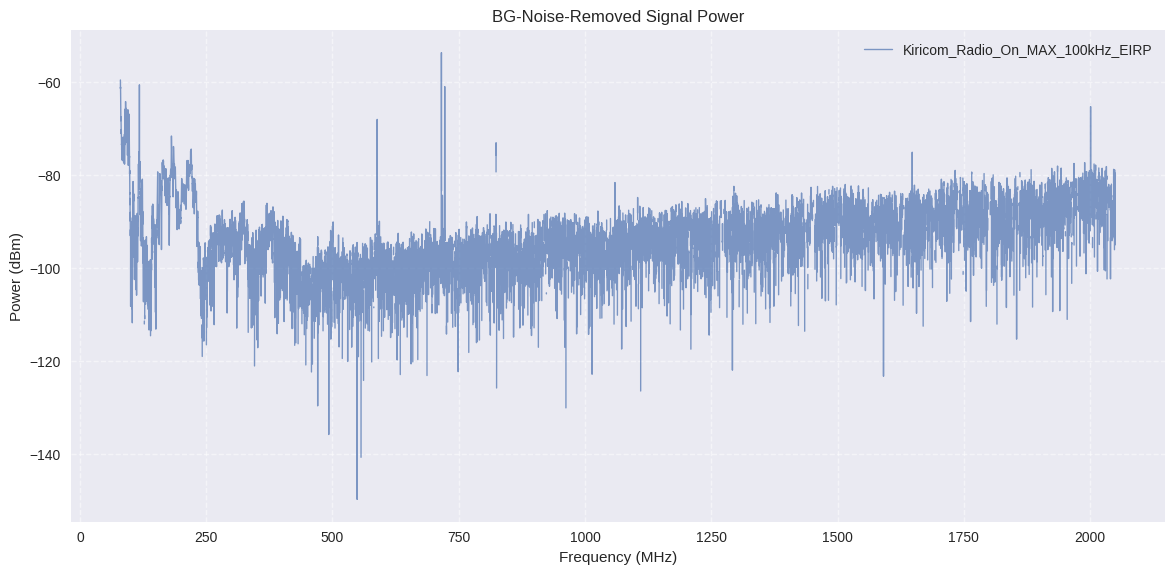

/tmp/ipykernel_5453/1096535012.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


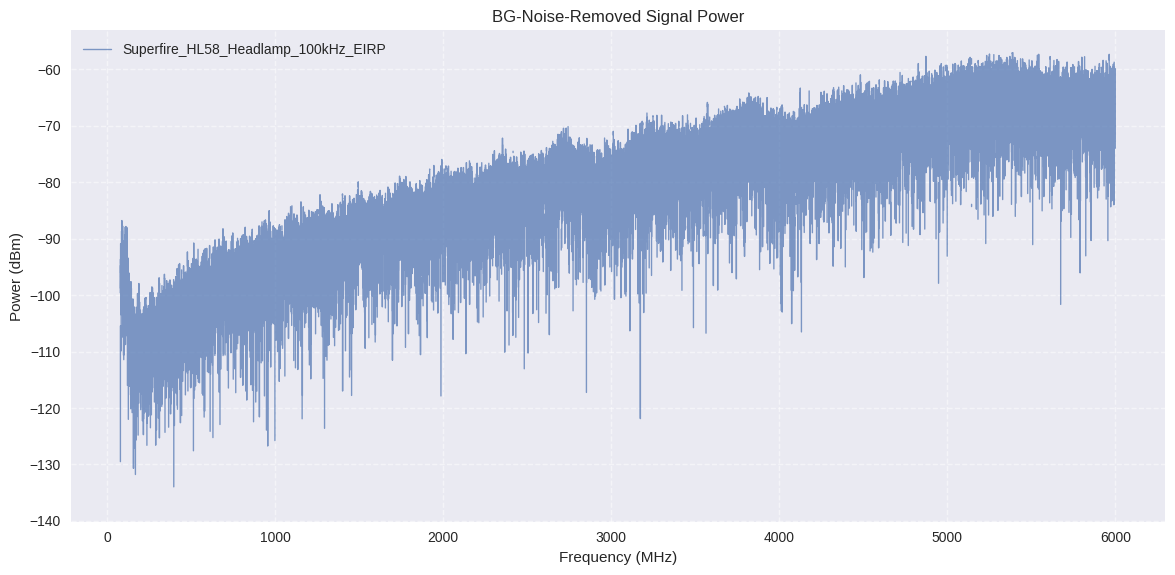

/tmp/ipykernel_5453/1096535012.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


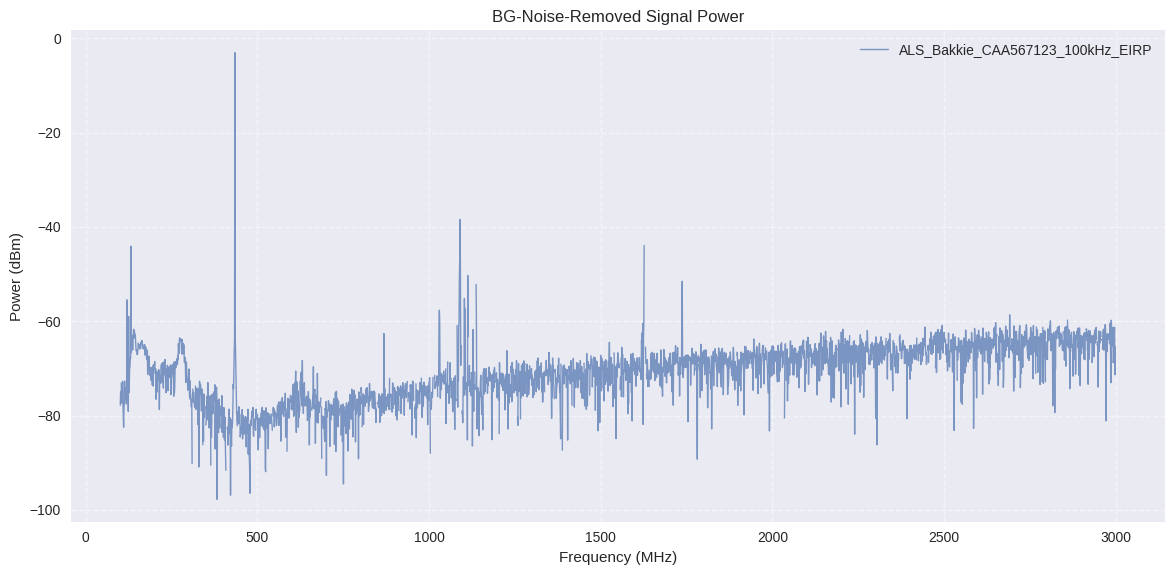

/tmp/ipykernel_5453/1096535012.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


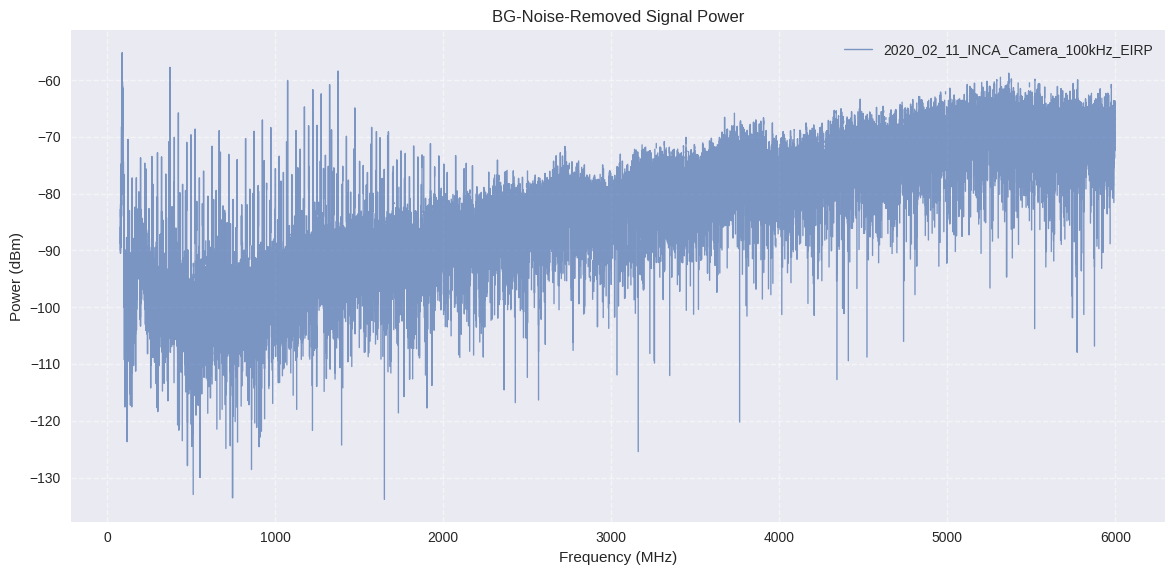

In [7]:
# inspect the backgorud substraction and save the 


for instrument_name, df in data.items():
    # Plot settings
    plt.style.use('seaborn')
    plt.figure(figsize=(12, 6))


    clean_signal = bg_remove(df['EIRP(dBm)'], df['BG_EIRP(dBm)'])


    # Plot with proper labels
    plt.plot(df['Frequency(MHz)'], clean_signal, 
             label=instrument_name, 
             alpha=0.7,
             linewidth=1)
    

    # Format plot
    plt.title('BG-Noise-Removed Signal Power')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Power (dBm)')
    #plt.xlim(50,350)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# `Save the backgroud substraction`


In [8]:
#for instrument_name, df in data.items():

    # # save to a dataframe
    # clean_instrument = {'Frequency (MHz)': df['Frequency(MHz)'],
    #               'Clean_EIRP(dBm)': clean_signal}
    # dataframe = pd.DataFrame(clean_instrument)
    # dataframe.to_csv(f'Data/Data_cleaned/{instrument_name}.csv')
    
    